In [1]:
%%capture
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import utils

In [2]:
import tensorflow as tf
from keras import layers, Model
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
2.15.0
1 Physical GPUs, 1 Logical GPUs


In [3]:
#set the necessary seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import datasets

### Breast cancer dataset

In [4]:
train_pairs_breast, val_pairs_breast, test_pairs_breast = utils.split_dataset(utils.create_list())
print(f"Number of training pairs: {len(train_pairs_breast)}")
print(f"Number of val pairs: {len(val_pairs_breast)}")
print(f"Number of test_pairs pairs: {len(test_pairs_breast)}")

Number of training pairs: 388
Number of val pairs: 129
Number of test_pairs pairs: 130


In [5]:
train_dataset_breast = utils.create_dataset(train_pairs_breast, augment=True)
val_dataset_breast = utils.create_dataset(val_pairs_breast)
test_dataset_breast = utils.create_dataset(test_pairs_breast)

In [6]:
batch_size = 8

In [7]:
#batch the dataset and shuffle the training set

train_dataset_breast = train_dataset_breast.shuffle(buffer_size=len(train_pairs_breast)).batch(batch_size)
val_dataset_breast = val_dataset_breast.batch(batch_size)
test_dataset_breast = test_dataset_breast.batch(batch_size)

### Skin cancer dataset

In [23]:
### Skin cancer dataset
train_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Training_Data", "ISIC-2017_Training_Part1_GroundTruth"), augment=True)
val_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Validation_Data", "ISIC-2017_Validation_Part1_GroundTruth"))
test_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Test_v2_Data", "ISIC-2017_Test_v2_Part1_GroundTruth"))

In [24]:
train_dataset_skin = train_dataset_skin.shuffle(buffer_size=2000).batch(batch_size)
val_dataset_skin = val_dataset_skin.batch(batch_size)
test_dataset_skin = test_dataset_skin.batch(batch_size)

### Brain cancer dataset

In [4]:
train_pairs_brain, val_pairs_brain, test_pairs_brain = utils.split_dataset(utils.create_list_brain())
print(f"Number of training pairs: {len(train_pairs_brain)}")
print(f"Number of val pairs: {len(val_pairs_brain)}")
print(f"Number of test_pairs pairs: {len(test_pairs_brain)}")

Number of training pairs: 1838
Number of val pairs: 613
Number of test_pairs pairs: 613


In [5]:
train_dataset_brain = utils.create_dataset(train_pairs_brain, augment=True)
val_dataset_brain = utils.create_dataset(val_pairs_brain)
test_dataset_brain = utils.create_dataset(test_pairs_brain)

In [8]:
train_dataset_brain = train_dataset_brain.shuffle(buffer_size=len(train_pairs_brain)).batch(batch_size)
val_dataset_brain = val_dataset_brain.batch(batch_size)
test_dataset_brain = test_dataset_brain.batch(batch_size)

## Architecture definition

In [8]:
# #convolutional layer
from keras import layers, Model
def convolutional_layer(input, num_filters, kernel_size=(3, 3), initializer="he_normal", dropout = False):

    #first convolution
    x = layers.Conv2D(filters=num_filters, kernel_size = kernel_size, padding='same', kernel_initializer=initializer)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if dropout:
        x = layers.Dropout(0.2)(x)

    #second convolution
    x = layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [9]:
def attention_gate(x, g, shape):
    #match dimensions of g and x
    g_down = layers.Conv2D(filters=shape, kernel_size=(1, 1), padding='same')(g)
    g_down = layers.BatchNormalization()(g_down)
    x_down = layers.Conv2D(filters=shape, kernel_size=(1, 1), padding='same')(x)
    x_down = layers.BatchNormalization()(x_down)

    #sum the features
    addition = layers.Add()([g_down, x_down])
    addition = layers.Activation('relu')(addition)

    #collapse the dimensions
    attention_map = layers.Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding='same')(addition)
    attention_map = layers.Activation('sigmoid')(attention_map)

    #final multiplication
    output = layers.Multiply()([x, attention_map])

    return output

In [10]:
def attention_unet(input_shape, num_filters=16):
    inputs = layers.Input(input_shape)

    #encoder block
    first_conv = convolutional_layer(inputs, num_filters)
    first_layer = layers.MaxPool2D(pool_size=(2, 2))(first_conv)

    second_conv = convolutional_layer(first_layer, num_filters * 2)
    second_layer = layers.MaxPool2D(pool_size=(2, 2))(second_conv)

    third_conv = convolutional_layer(second_layer, num_filters * 4)
    third_layer = layers.MaxPool2D(pool_size=(2, 2))(third_conv)

    fourth_conv = convolutional_layer(third_layer, num_filters * 8)
    fourth_layer = layers.MaxPool2D(pool_size=(2, 2))(fourth_conv)

    fifth_conv = convolutional_layer(fourth_layer, num_filters * 16)

    #decoder block with attention
    first_deconv = layers.UpSampling2D(interpolation="bilinear")(fifth_conv)
    first_att = attention_gate(fourth_conv, first_deconv, num_filters * 8)
    sixth_layer = layers.concatenate([first_deconv, first_att])
    sixth_conv = convolutional_layer(sixth_layer, num_filters * 8)

    second_deconv = layers.UpSampling2D(interpolation="bilinear")(sixth_conv)
    second_att = attention_gate(third_conv, second_deconv, num_filters * 4)
    seventh_layer = layers.concatenate([second_deconv, second_att])
    seventh_conv = convolutional_layer(seventh_layer, num_filters * 4)

    third_deconv = layers.UpSampling2D(interpolation="bilinear")(seventh_conv)
    third_att = attention_gate(second_conv, third_deconv, num_filters * 2)
    eighth_layer = layers.concatenate([third_deconv, third_att])
    eighth_conv = convolutional_layer(eighth_layer, num_filters * 2)

    fourth_deconv = layers.UpSampling2D(interpolation="bilinear")(eighth_conv)
    fourth_att = attention_gate(first_conv, fourth_deconv, num_filters)
    ninth_layer = layers.concatenate([fourth_deconv, fourth_att])
    ninth_conv = convolutional_layer(ninth_layer, num_filters)

    #output layer
    output = layers.Conv2D(1, kernel_size=(1, 1), activation="sigmoid")(ninth_conv)

    attention_unet = Model(inputs=inputs, outputs=output)

    return attention_unet

In [11]:
tf.keras.utils.get_custom_objects()["dice_loss"] = utils.dice_loss
tf.keras.utils.get_custom_objects()["bce_dice_loss"] = utils.bce_dice_loss
tf.keras.utils.get_custom_objects()["tversky_loss"] = utils.tversky_loss
tf.keras.utils.get_custom_objects()["dice_coefficient"] = utils.dice_coefficient
tf.keras.utils.get_custom_objects()["iou"] = utils.iou

In [12]:
attention_unet_model = attention_unet(input_shape=(256, 256, 3))

In [19]:
attention_unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_103 (Conv2D)         (None, 256, 256, 16)         448       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_88 (Ba  (None, 256, 256, 16)         64        ['conv2d_103[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_88 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_88

### Fit on the breast cancer dataset

In [28]:
#non cambiare!!

best_history_breast = attention_unet.fit(train_dataset_breast, validation_data=val_dataset_breast, epochs=100, callbacks=[lr_adapter, early_stopping])

Epoch 1/100


I0000 00:00:1738928898.491832      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 [==============================] - 46s 349ms/step - loss: 0.6390 - dice_coefficient: 0.2793 - iou: 0.1648 - accuracy: 0.6216 - val_loss: 0.7545 - val_dice_coefficient: 0.1620 - val_iou: 0.0897 - val_accuracy: 0.3321 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 7s 111ms/step - loss: 0.5679 - dice_coefficient: 0.3416 - iou: 0.2096 - accuracy: 0.6907 - val_loss: 0.7502 - val_dice_coefficient: 0.1604 - val_iou: 0.0887 - val_accuracy: 0.1788 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 7s 112ms/step - loss: 0.5234 - dice_coefficient: 0.3871 - iou: 0.2450 - accuracy: 0.7485 - val_loss: 0.6537 - val_dice_coefficient: 0.2372 - val_iou: 0.1380 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 7s 111ms/step - loss: 0.5021 - dice_coefficient: 0.4200 - iou: 0.2717 - accuracy: 0.7905 - val_loss: 0.6855 - val_dice_coefficient: 0.2093 - val_iou: 0.1196 - val_accuracy: 0.4428 - lr: 0.0010
Epoch 5/100
49/49 [========

In [14]:
history_breast = attention_unet.fit(train_dataset_breast, validation_data=val_dataset_breast, epochs=100, callbacks=[lr_adapter, early_stopping])

Epoch 1/100


I0000 00:00:1739102950.113188      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 [==============================] - 44s 327ms/step - loss: 0.6867 - dice_coefficient: 0.2386 - iou: 0.1373 - accuracy: 0.5291 - precision: 0.1643 - recall: 0.7015 - val_loss: 0.7661 - val_dice_coefficient: 0.1491 - val_iou: 0.0819 - val_accuracy: 0.0890 - val_precision: 0.0871 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 7s 117ms/step - loss: 0.6031 - dice_coefficient: 0.3049 - iou: 0.1825 - accuracy: 0.6963 - precision: 0.2512 - recall: 0.7493 - val_loss: 0.7592 - val_dice_coefficient: 0.1540 - val_iou: 0.0848 - val_accuracy: 0.1342 - val_precision: 0.0913 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 7s 116ms/step - loss: 0.5614 - dice_coefficient: 0.3455 - iou: 0.2124 - accuracy: 0.7416 - precision: 0.2881 - recall: 0.7549 - val_loss: 0.7616 - val_dice_coefficient: 0.1523 - val_iou: 0.0838 - val_accuracy: 0.1184 - val_precision: 0.0898 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/100
49/49 [========

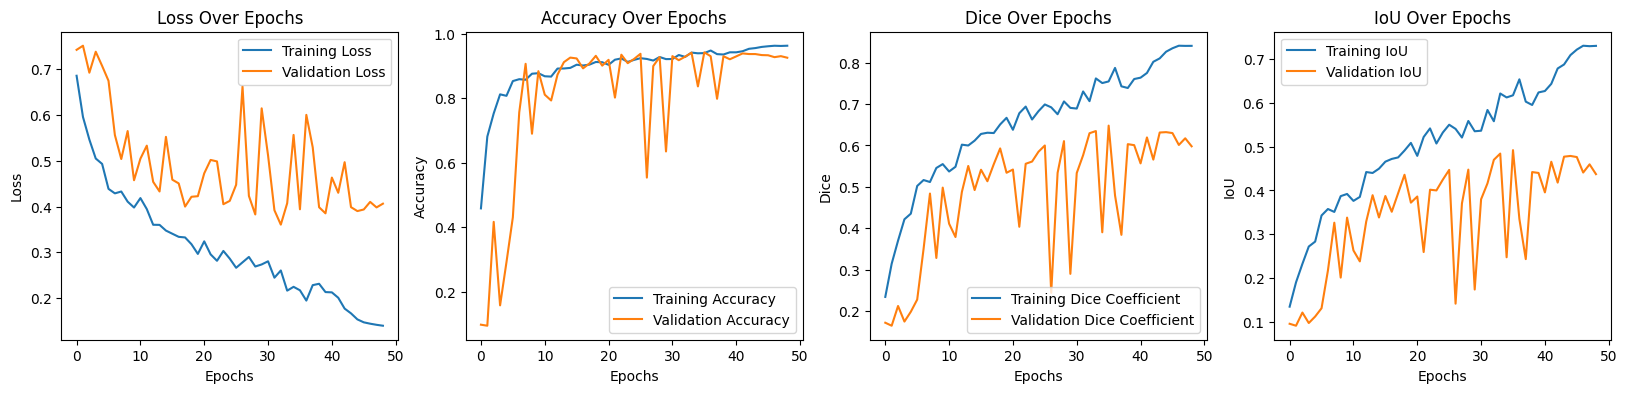

In [19]:
history_dict = history_breast.history

#plot Loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

#plot accuracy
if 'accuracy' in history_dict:
    plt.subplot(1, 4, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

#plot dice
if 'dice_coefficient' in history_dict:
    plt.subplot(1, 4, 3)
    plt.plot(history_dict['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history_dict['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.title('Dice Over Epochs')
    plt.legend()

#plot iou
if 'iou' in history_dict:
    plt.subplot(1, 4, 4)
    plt.plot(history_dict['iou'], label='Training IoU')
    plt.plot(history_dict['val_iou'], label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Over Epochs')
    plt.legend()

plt.show()

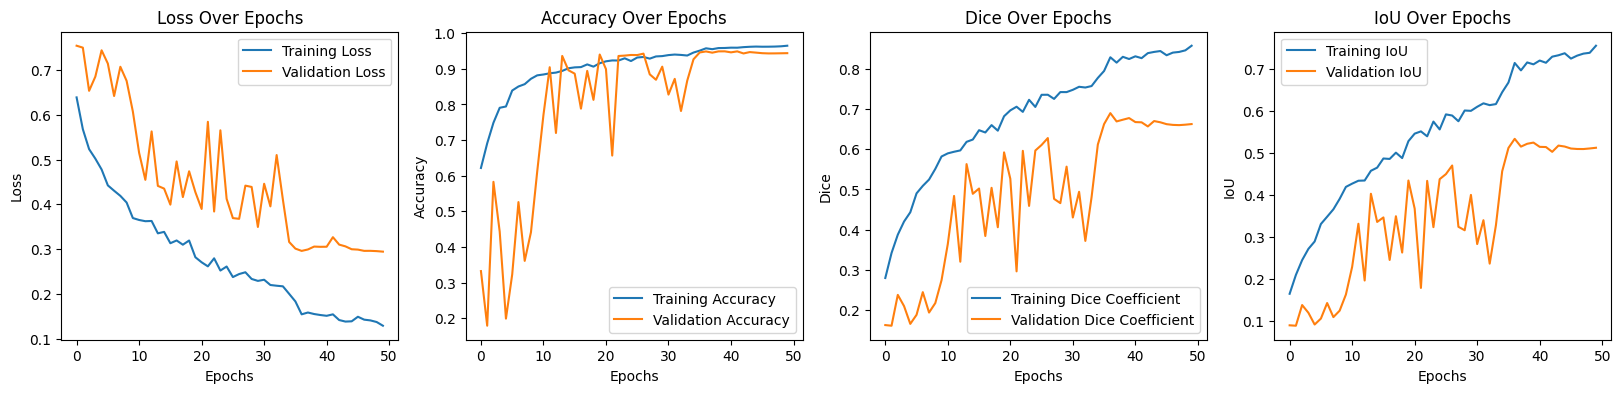

In [29]:
#non cambiare!!!

history_dict = history_breast.history

#plot Loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

#plot accuracy
if 'accuracy' in history_dict:
    plt.subplot(1, 4, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

#plot dice
if 'dice_coefficient' in history_dict:
    plt.subplot(1, 4, 3)
    plt.plot(history_dict['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history_dict['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.title('Dice Over Epochs')
    plt.legend()

#plot iou
if 'iou' in history_dict:
    plt.subplot(1, 4, 4)
    plt.plot(history_dict['iou'], label='Training IoU')
    plt.plot(history_dict['val_iou'], label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Over Epochs')
    plt.legend()

plt.show()

In [18]:
attention_unet.save("attention_unet_best_breast.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
test_loss, test_dice, test_iou, test_accuracy, test_precision, test_recall = attention_unet.evaluate(test_dataset_breast)

17/17 [==============================] - 1s 42ms/step - loss: 0.3711 - dice_coefficient: 0.6210 - iou: 0.4595 - accuracy: 0.9306 - precision: 0.6060 - recall: 0.6584


1/1 [==============================] - 1s 716ms/step


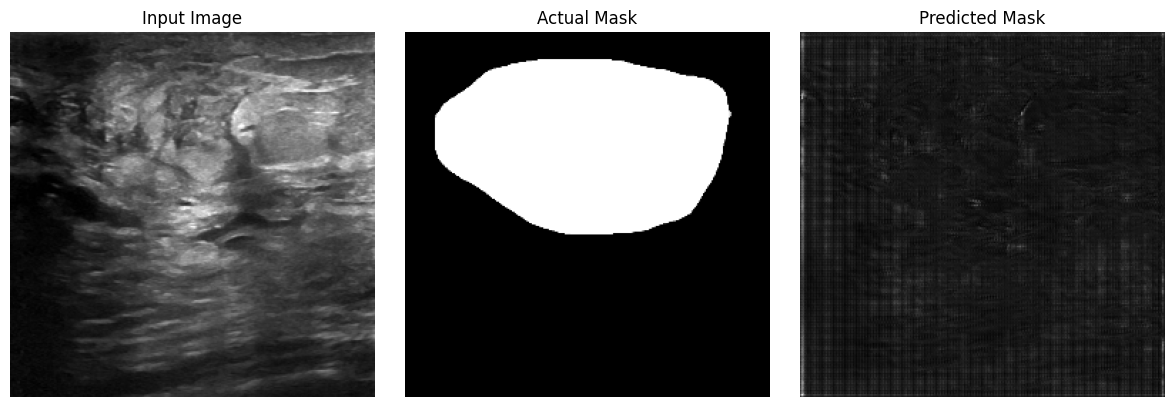

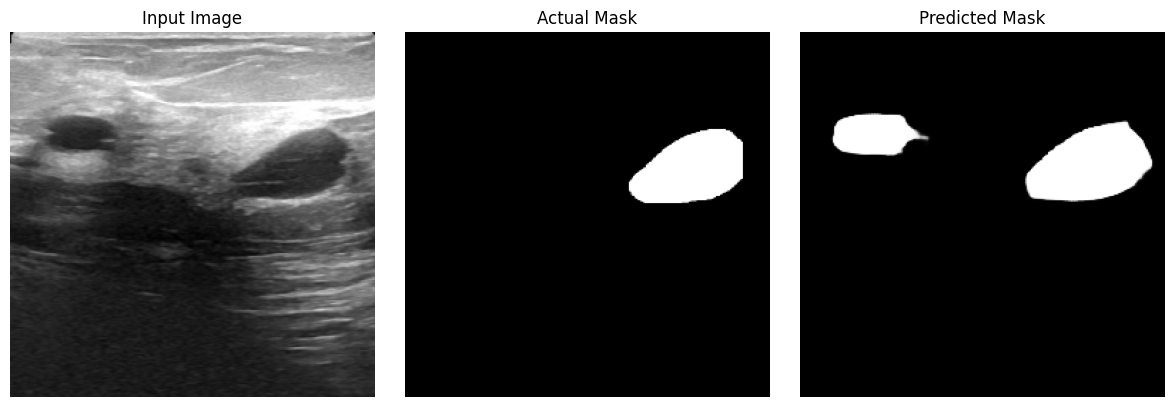

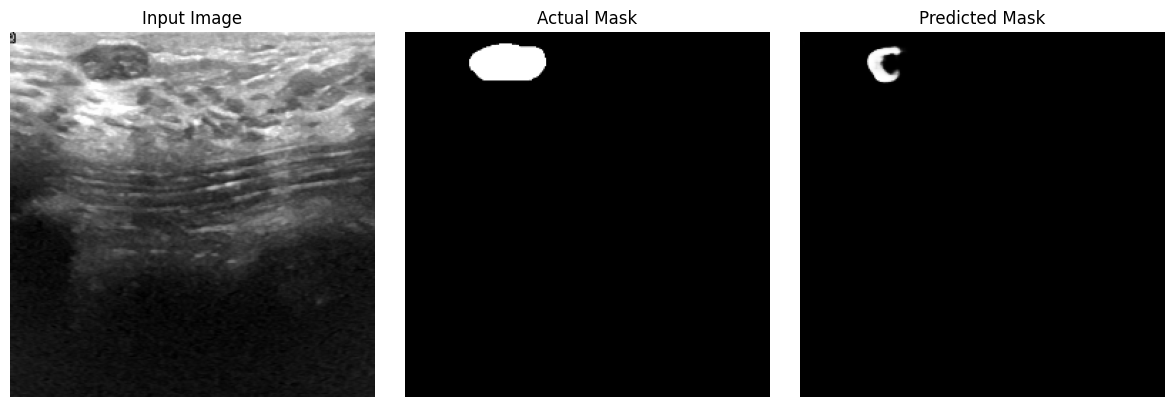

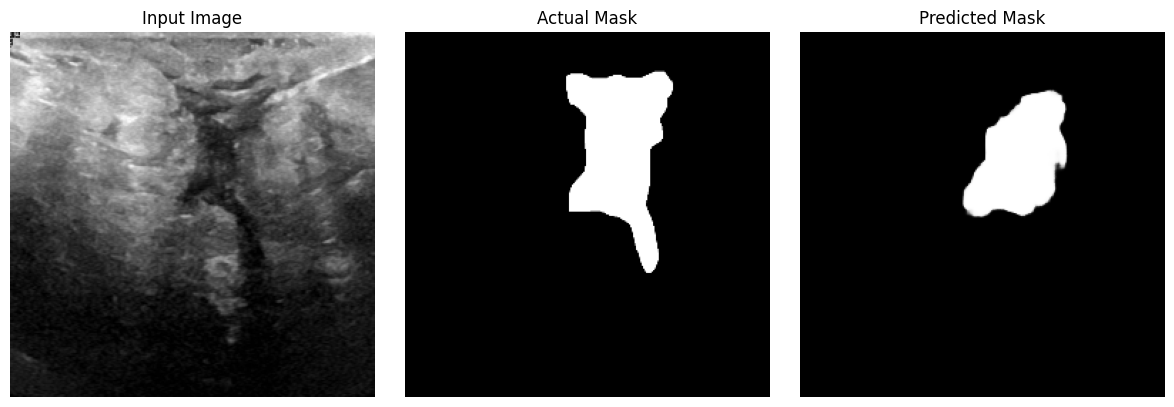

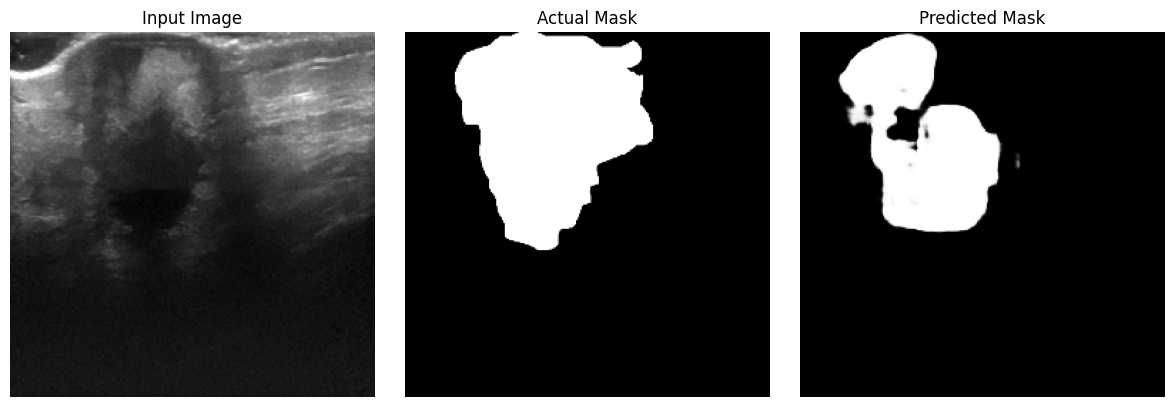

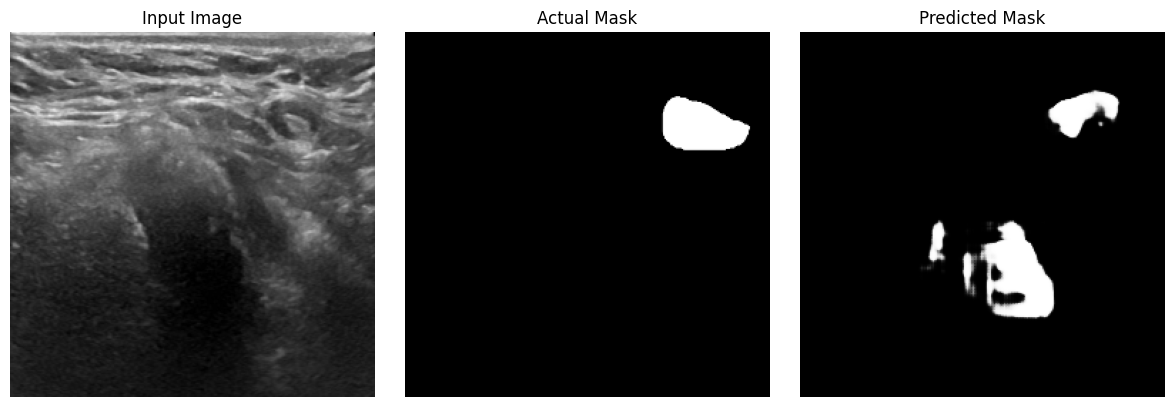

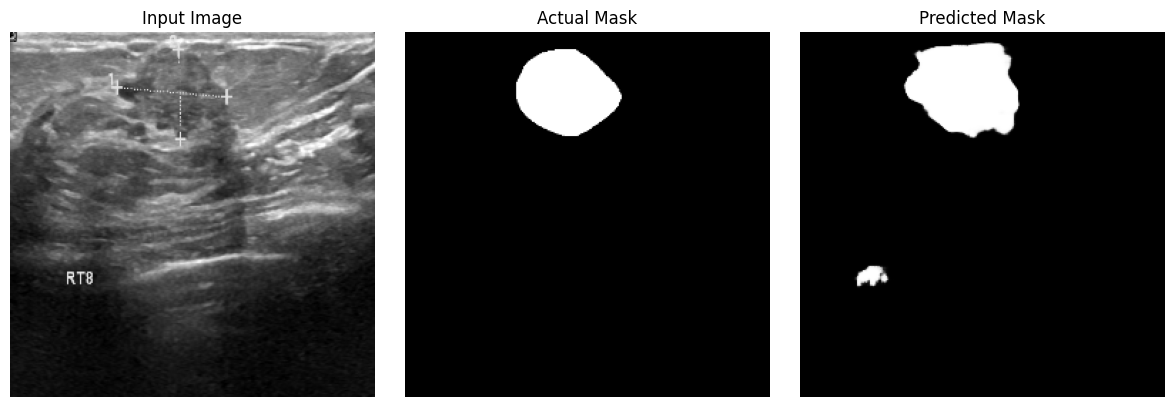

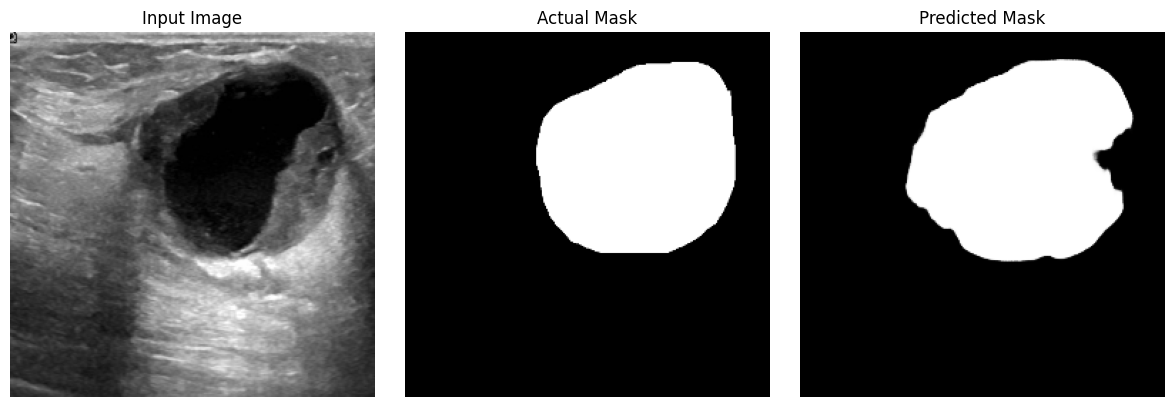

In [19]:
for i, (image, mask) in enumerate(test_dataset_breast.take(1)):
    predicted_mask = attention_unet.predict(image)

    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
training_times = []

num_experiments = 5
input_size = (256, 256, 3)

best_dice = 0.0

for i in range(num_experiments):
    print(f"Training experiment {i+1}/{num_experiments}")

    #create and compile U-Net
    attention_unet_model = attention_unet(input_size)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    attention_unet_model.compile(optimizer=optimizer,
                       loss=utils.tversky_loss,
                       metrics=[utils.dice_coefficient, utils.iou, "accuracy", tf.keras.metrics.Precision(name="precision_metric"), tf.keras.metrics.Recall(name="recall_metric")])

    callbacks = [
        EarlyStopping(monitor='val_dice_coefficient', patience=13, restore_best_weights=True, mode='max', verbose=0),
        ReduceLROnPlateau(monitor='val_dice_metric', factor=0.1, patience=7, min_lr=1e-6, mode='max', verbose=0)
    ]

    start_time = time.time()

    history = attention_unet_model.fit(train_dataset_breast, validation_data=val_dataset_breast, epochs=100, callbacks=callbacks, verbose=0)

    elapsed_time = time.time() - start_time
    training_times.append(elapsed_time)
    print(f"Training Time for Experiment {i+1}: {elapsed_time:.2f} seconds")

    #select best epoch in terms of dice
    best_epoch_index = np.argmax(history.history['val_dice_coefficient'])

    #get the metrics for that epoch
    final_dice = round(history.history['val_dice_coefficient'][best_epoch_index], 3)
    final_iou = round(history.history['val_iou'][best_epoch_index], 3)
    final_precision = round(history.history['val_precision_metric'][best_epoch_index], 3)
    final_recall = round(history.history['val_recall_metric'][best_epoch_index], 3)
    final_accuracy = round(history.history['val_accuracy'][best_epoch_index], 3)

    #store the results
    dice_scores.append(final_dice)
    iou_scores.append(final_iou)
    precision_scores.append(final_precision)
    recall_scores.append(final_recall)
    accuracy_scores.append(final_accuracy)

    print(f"Dice Coefficient: {final_dice}", f"IoU: {final_iou}", f"Precision: {final_precision}", f"Recall: {final_recall}", f"Accuracy: {final_accuracy}")

    # Save best model based on Dice score
    if final_dice > best_dice:
        best_dice = final_dice
        best_model = attention_unet_model
        attention_unet_model.save("best_attention_unet_breast.h5")
        print(f"New best model saved")

# Compute mean ± std
dice_mean, dice_std = np.mean(dice_scores), np.std(dice_scores)
iou_mean, iou_std = np.mean(iou_scores), np.std(iou_scores)
precision_mean, precision_std = np.mean(precision_scores), np.std(precision_scores)
recall_mean, recall_std = np.mean(recall_scores), np.std(recall_scores)
accuracy_mean, accuracy_std = np.mean(accuracy_scores), np.std(accuracy_scores)
time_mean, time_std = np.mean(training_times), np.std(training_times)

print("Final Results (Across All Runs):")
print(f"Dice Score: {dice_mean:.2f} ± {dice_std:.2f}")
print(f"IoU Score: {iou_mean:.2f} ± {iou_std:.2f}")
print(f"Precision Score: {precision_mean:.2f} ± {precision_std:.2f}")
print(f"Recall Score: {recall_mean:.2f} ± {recall_std:.2f}")
print(f"Accuracy Score: {accuracy_mean:.2f} ± {accuracy_std:.2f}")
print(f"Training Time: {time_mean:.2f} ± {time_std:.2f} seconds")
print(f"Best Model Dice Score: {best_dice:.4f} (Saved as 'best_attention_unet_breast.h5')")

Training experiment 1/5


I0000 00:00:1739213419.789170   50525 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Time for Experiment 1: 419.85 seconds
Dice Coefficient: 0.643 IoU: 0.479 Precision: 0.657 Recall: 0.65 Accuracy: 0.939


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved
Training experiment 2/5
Training Time for Experiment 2: 498.93 seconds
Dice Coefficient: 0.675 IoU: 0.514 Precision: 0.667 Recall: 0.715 Accuracy: 0.943
New best model saved
Training experiment 3/5
Training Time for Experiment 3: 331.40 seconds
Dice Coefficient: 0.609 IoU: 0.444 Precision: 0.62 Recall: 0.639 Accuracy: 0.934
Training experiment 4/5
Training Time for Experiment 4: 603.66 seconds
Dice Coefficient: 0.678 IoU: 0.52 Precision: 0.69 Recall: 0.669 Accuracy: 0.944
New best model saved
Training experiment 5/5
Training Time for Experiment 5: 481.51 seconds
Dice Coefficient: 0.631 IoU: 0.467 Precision: 0.591 Recall: 0.709 Accuracy: 0.931
Final Results (Across All Runs):
Dice Score: 0.65 ± 0.03
IoU Score: 0.48 ± 0.03
Precision Score: 0.64 ± 0.04
Recall Score: 0.68 ± 0.03
Accuracy Score: 0.94 ± 0.01
Training Time: 467.07 ± 90.02 seconds
Best Model Dice Score: 0.6780 (Saved as 'best_attention_unet_breast.h5')


In [14]:
best_attention_unet_breast = tf.keras.models.load_model("best_attention_unet_breast.h5")

In [15]:
test_loss, test_dice, test_iou, test_precision, test_recall, test_accuracy = best_attention_unet_breast.evaluate(test_dataset_breast)

17/17 [==============================] - 3s 137ms/step - loss: 0.4010 - dice_coefficient: 0.6126 - iou: 0.4592 - accuracy: 0.9351 - precision_metric: 0.6525 - recall_metric: 0.5932


1/1 [==============================] - 1s 575ms/step


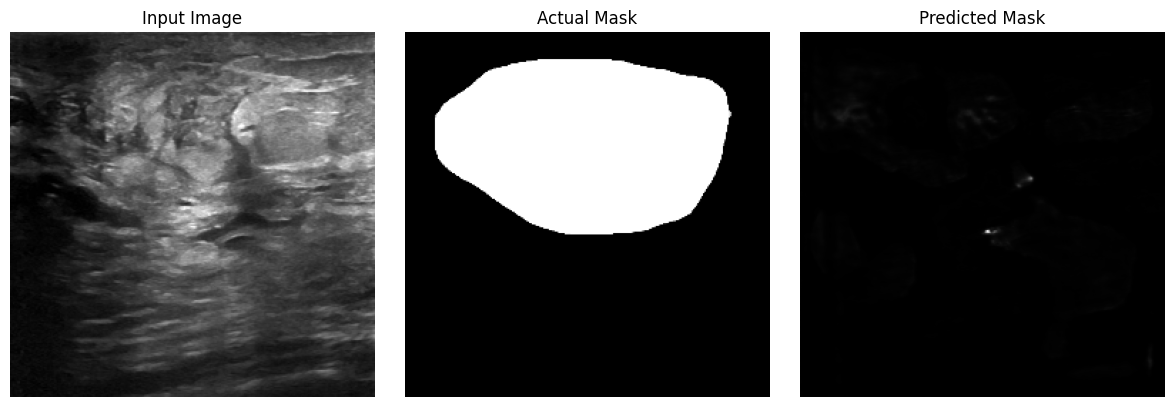

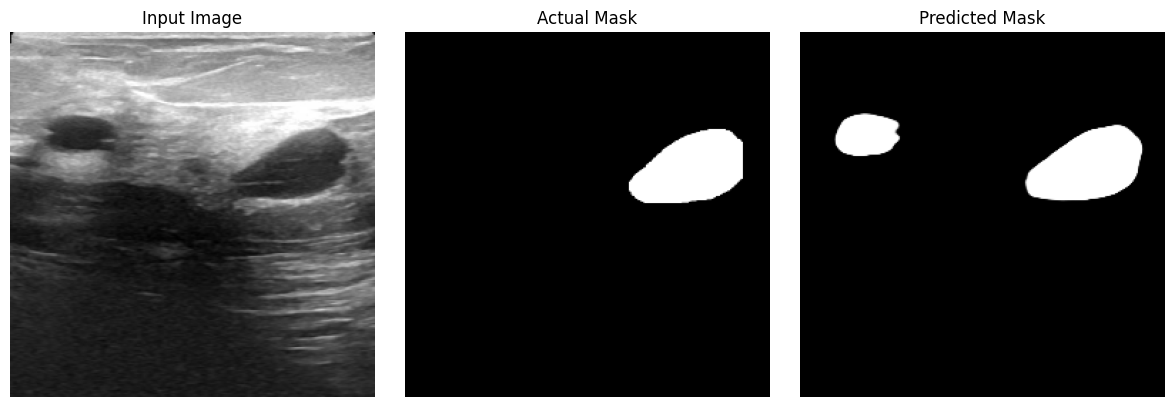

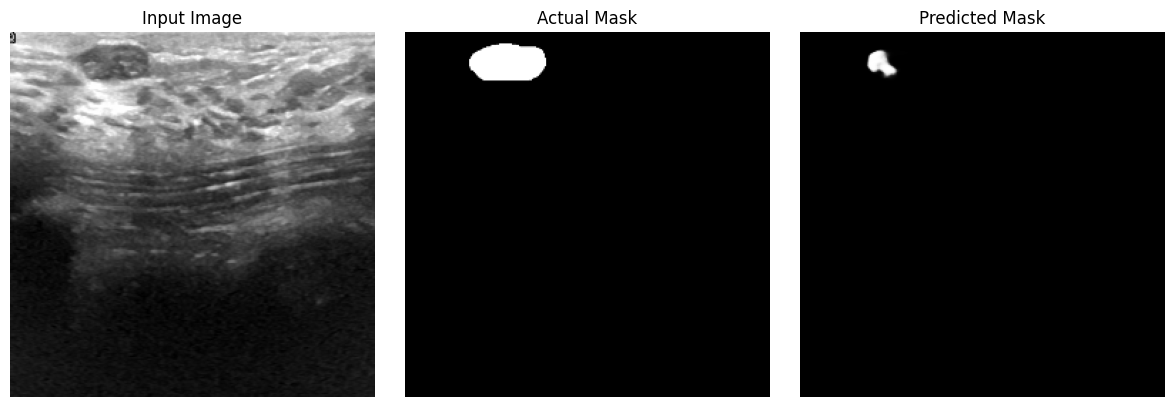

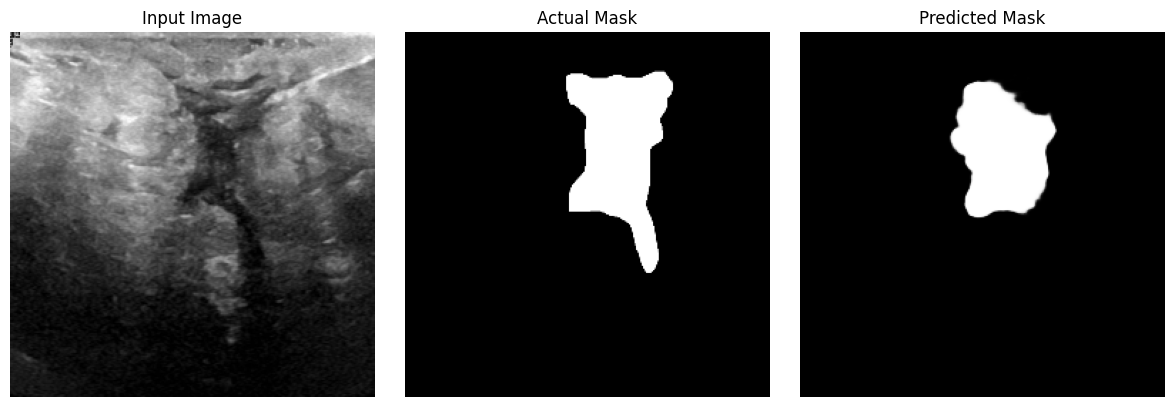

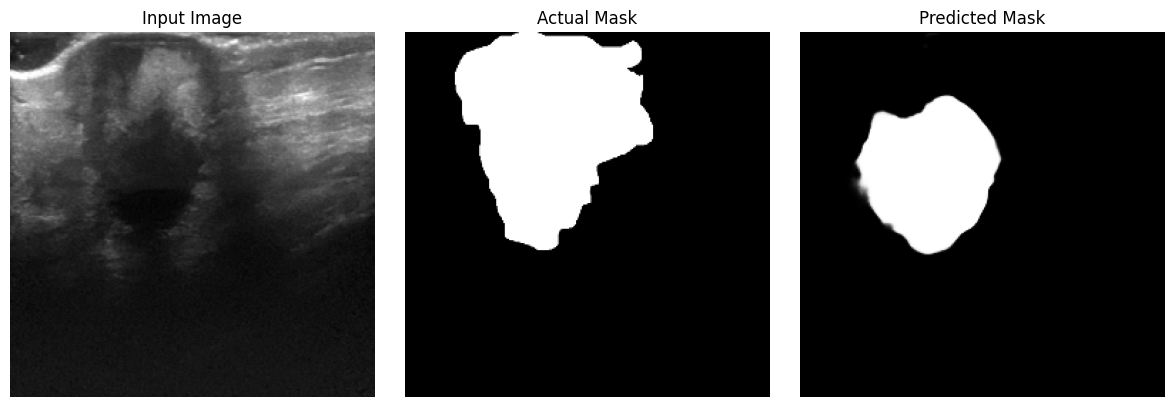

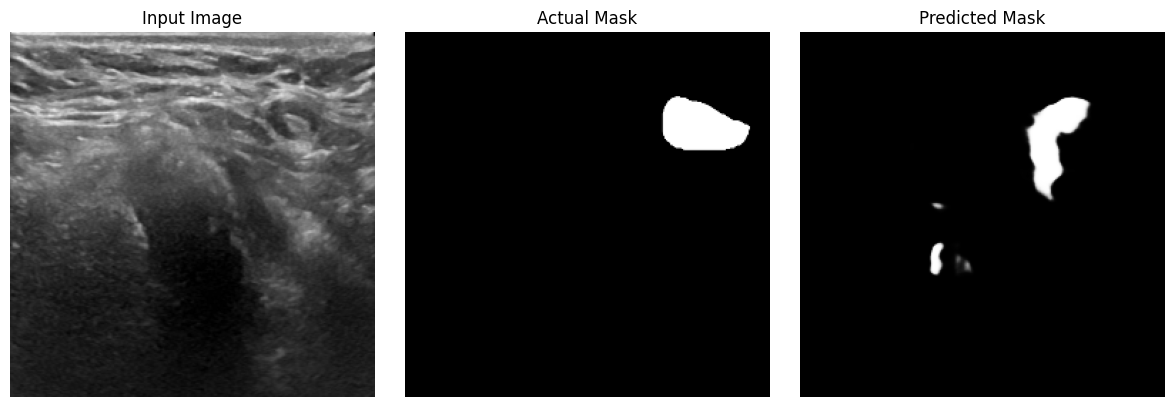

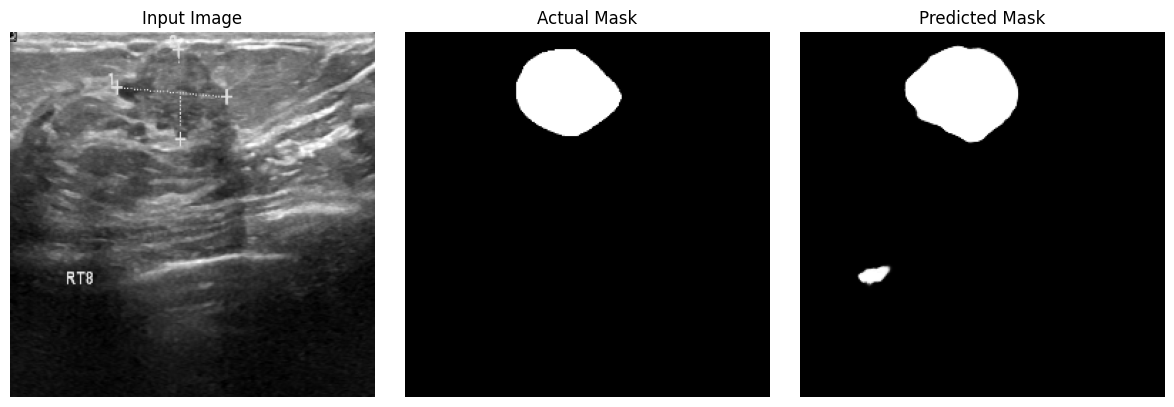

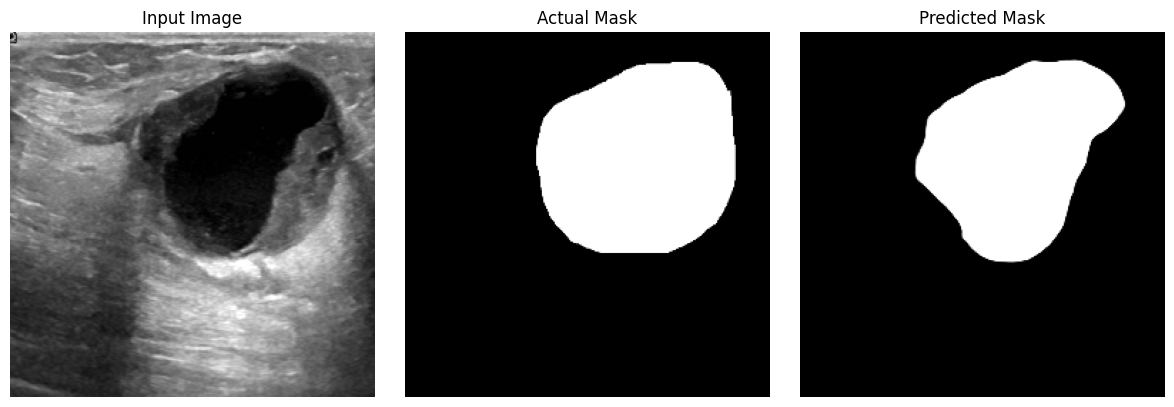

In [16]:
for i, (image, mask) in enumerate(test_dataset_breast.take(1)):
    predicted_mask = best_attention_unet_breast.predict(image)

    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

### Fit on the skin cancer dataset

In [25]:
best_history_skin = attention_unet.fit(train_dataset_skin, epochs=100, validation_data=val_dataset_skin, callbacks=[lr_adapter, early_stopping])

Epoch 1/100
250/250 [==============================] - 80s 143ms/step - loss: 0.3099 - dice_coefficient: 0.6232 - iou: 0.4648 - accuracy: 0.8082 - precision_1: 0.5641 - recall_1: 0.8428 - val_loss: 0.4483 - val_dice_coefficient: 0.4564 - val_iou: 0.3190 - val_accuracy: 0.7001 - val_precision_1: 0.3596 - val_recall_1: 0.9283 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - 59s 128ms/step - loss: 0.2314 - dice_coefficient: 0.7274 - iou: 0.5820 - accuracy: 0.8682 - precision_1: 0.6803 - recall_1: 0.8402 - val_loss: 0.3941 - val_dice_coefficient: 0.5140 - val_iou: 0.3681 - val_accuracy: 0.7592 - val_precision_1: 0.4139 - val_recall_1: 0.9246 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 60s 133ms/step - loss: 0.2030 - dice_coefficient: 0.7640 - iou: 0.6272 - accuracy: 0.8844 - precision_1: 0.7177 - recall_1: 0.8471 - val_loss: 0.3408 - val_dice_coefficient: 0.6092 - val_iou: 0.4570 - val_accuracy: 0.8620 - val_precision_1: 0.5733 - val_recall_1: 0.8

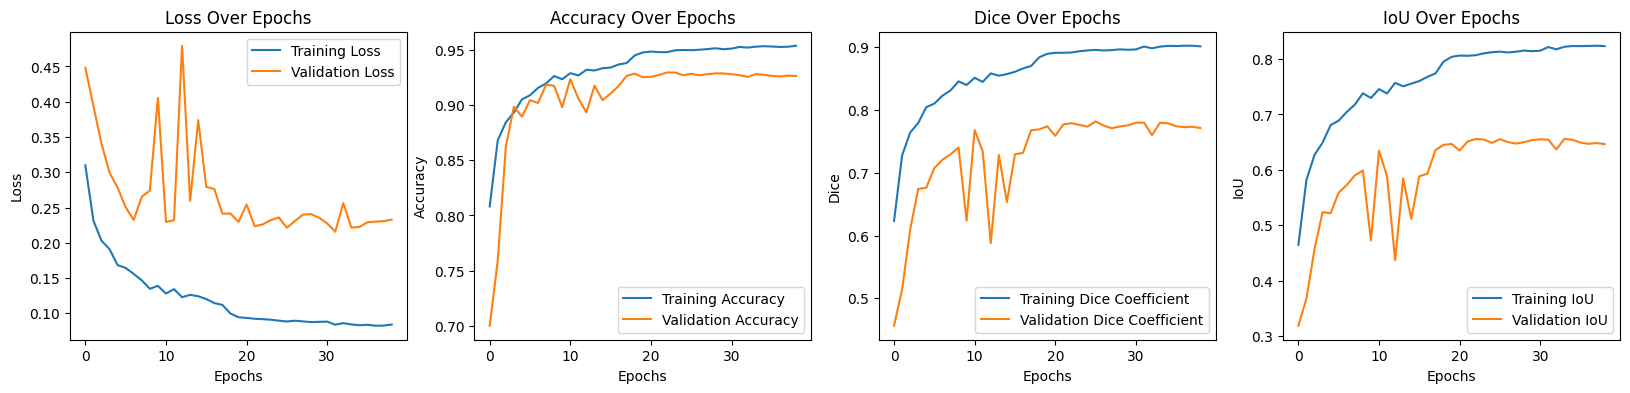

In [26]:
history_dict = best_history_skin.history

#plot Loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

#plot accuracy
if 'accuracy' in history_dict:
    plt.subplot(1, 4, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

#plot dice
if 'dice_coefficient' in history_dict:
    plt.subplot(1, 4, 3)
    plt.plot(history_dict['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history_dict['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.title('Dice Over Epochs')
    plt.legend()

#plot iou
if 'iou' in history_dict:
    plt.subplot(1, 4, 4)
    plt.plot(history_dict['iou'], label='Training IoU')
    plt.plot(history_dict['val_iou'], label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Over Epochs')
    plt.legend()

plt.show()

In [27]:
attention_unet.save("attention_unet_best_skin.h5")

In [28]:
test_loss_skin, test_dice_skin, test_iou_skin, test_accuracy_skin, test_precision_skin, test_recall_skin = attention_unet.evaluate(test_dataset_skin)

75/75 [==============================] - 22s 295ms/step - loss: 0.2172 - dice_coefficient: 0.8049 - iou: 0.6856 - accuracy: 0.9211 - precision_1: 0.9002 - recall_1: 0.7532


1/1 [==============================] - 1s 614ms/step


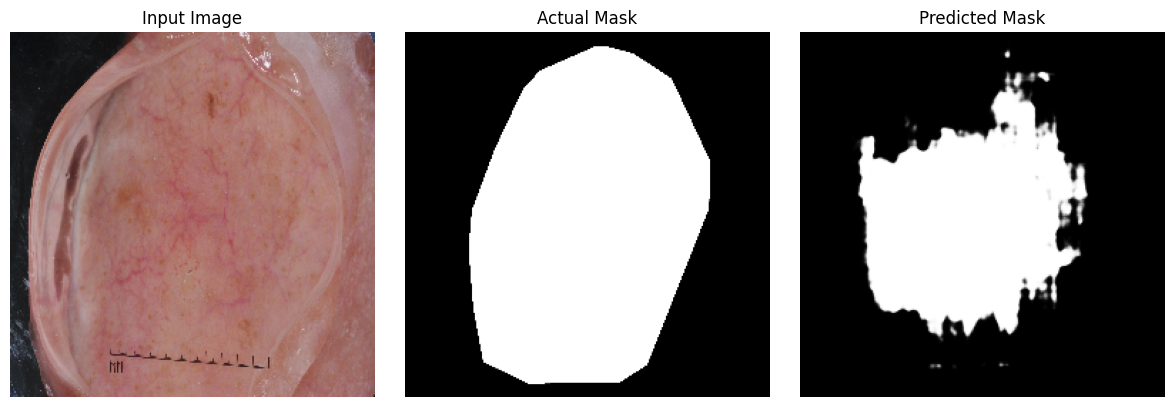

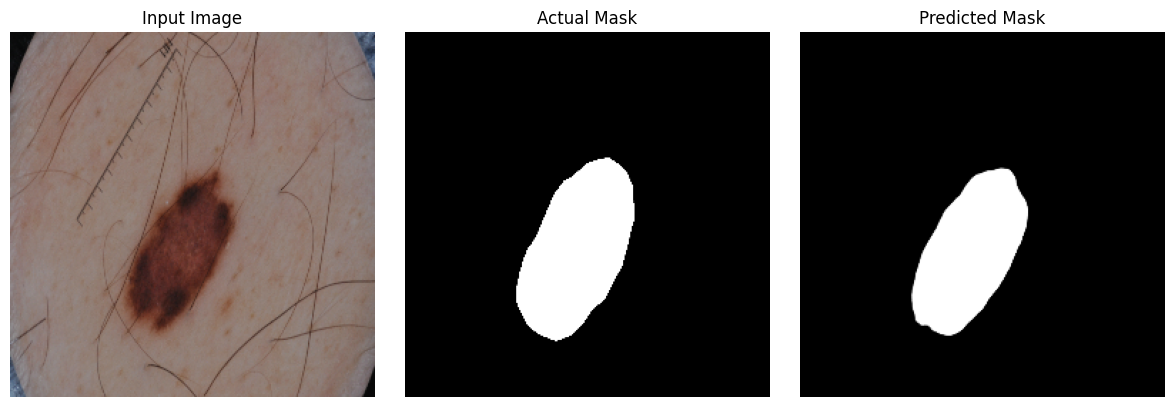

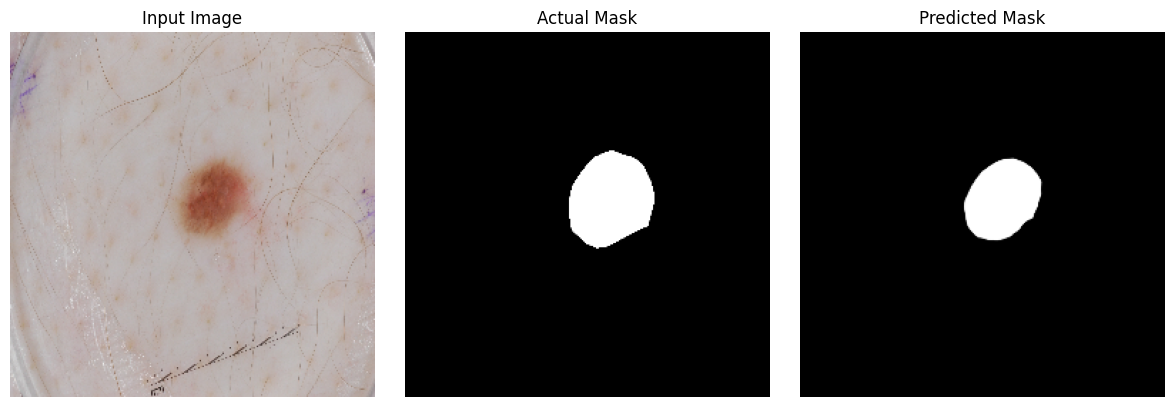

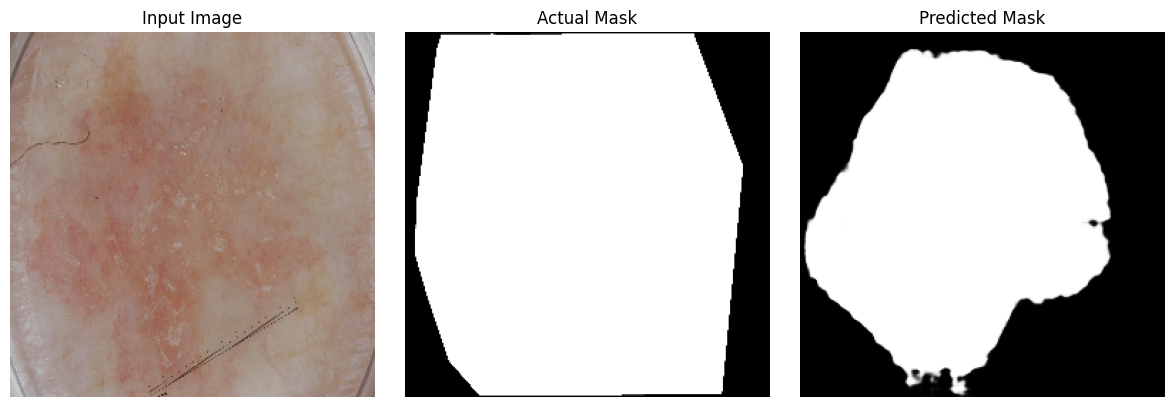

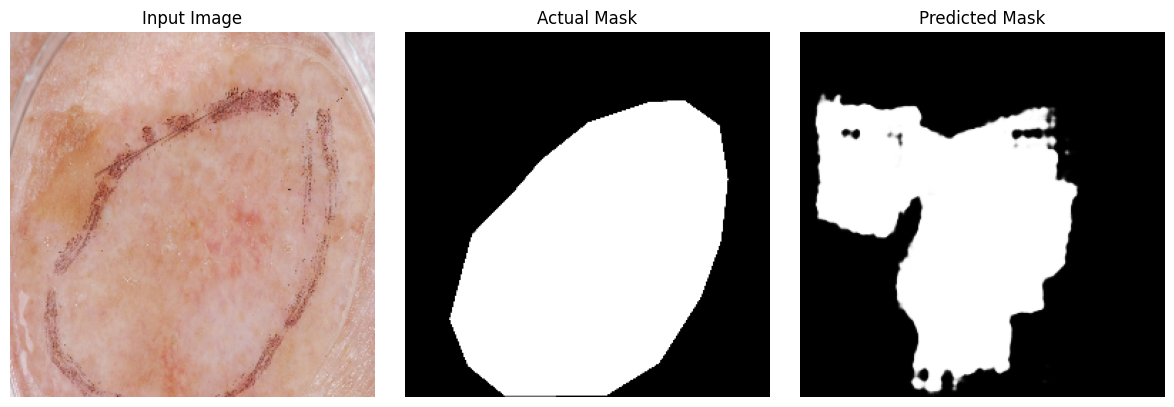

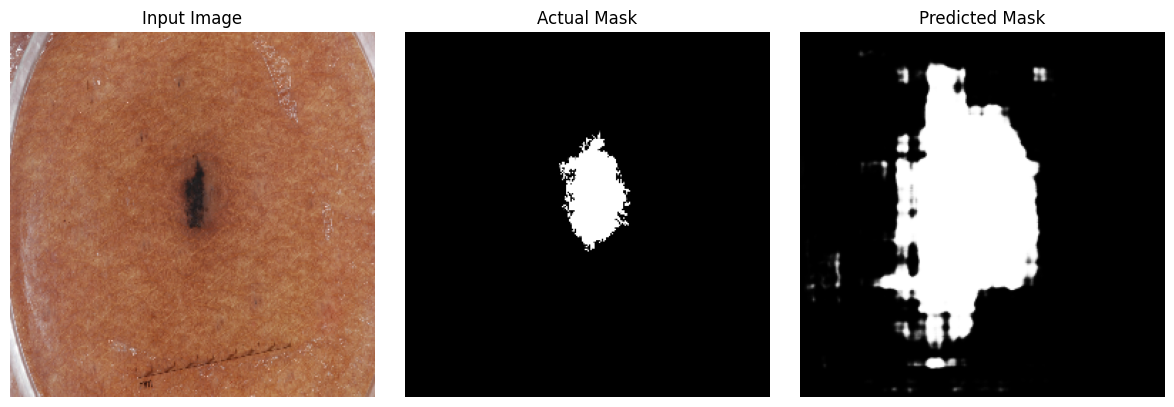

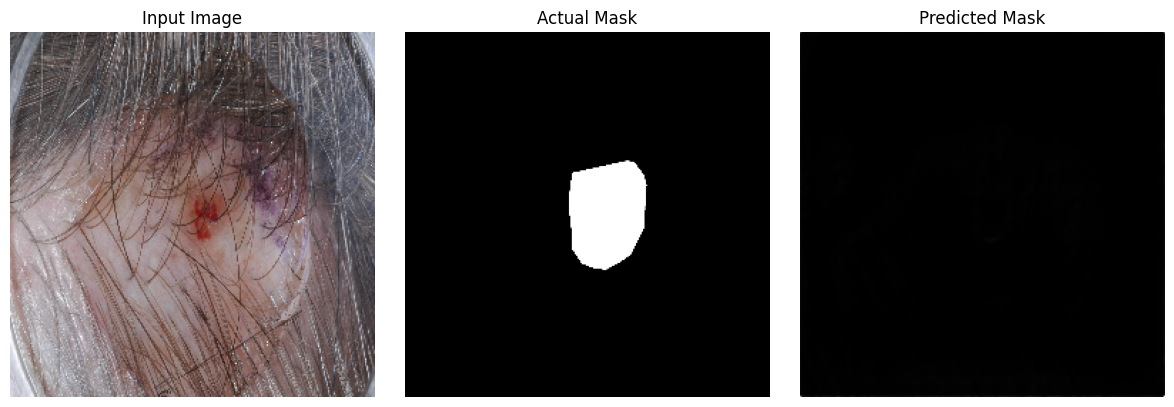

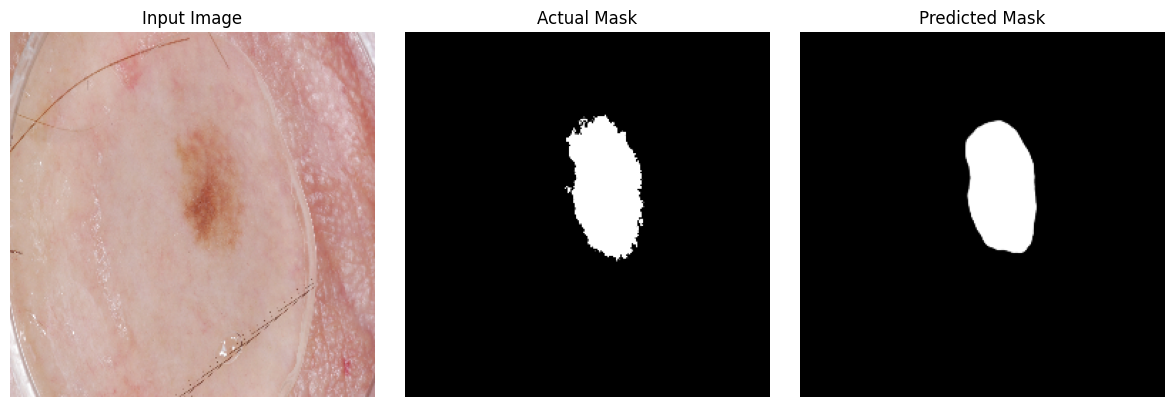

In [29]:
for i, (image, mask) in enumerate(test_dataset_skin.take(1)):
    predicted_mask = attention_unet.predict(image)
    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

### Fit on the brain cancer dataset

In [14]:
history = attention_unet.fit(train_dataset_brain, validation_data=val_dataset_brain, epochs=100, callbacks=[lr_adapter, early_stopping])

Epoch 1/100


I0000 00:00:1739115372.349008    7255 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


230/230 [==============================] - 81s 206ms/step - loss: 0.8464 - dice_coefficient: 0.1021 - iou: 0.0544 - accuracy: 0.7381 - precision: 0.0598 - recall: 0.7565 - val_loss: 0.9077 - val_dice_coefficient: 0.0608 - val_iou: 0.0315 - val_accuracy: 0.8450 - val_precision: 0.0451 - val_recall: 0.3851 - lr: 0.0010
Epoch 2/100
230/230 [==============================] - 46s 174ms/step - loss: 0.6970 - dice_coefficient: 0.2446 - iou: 0.1425 - accuracy: 0.9393 - precision: 0.1798 - recall: 0.5036 - val_loss: 0.6571 - val_dice_coefficient: 0.2823 - val_iou: 0.1672 - val_accuracy: 0.9558 - val_precision: 0.2066 - val_recall: 0.5199 - lr: 0.0010
Epoch 3/100
230/230 [==============================] - 52s 200ms/step - loss: 0.5911 - dice_coefficient: 0.3698 - iou: 0.2331 - accuracy: 0.9653 - precision: 0.3105 - recall: 0.4821 - val_loss: 0.7275 - val_dice_coefficient: 0.2488 - val_iou: 0.1457 - val_accuracy: 0.9678 - val_precision: 0.2197 - val_recall: 0.3173 - lr: 0.0010
Epoch 4/100
230/230

In [15]:
test_loss, test_dice, test_iou, test_accuracy, test_precision, test_recall = attention_unet.evaluate(test_dataset_brain)

77/77 [==============================] - 4s 45ms/step - loss: 0.2474 - dice_coefficient: 0.7492 - iou: 0.6061 - accuracy: 0.9910 - precision: 0.7665 - recall: 0.7569


In [16]:
attention_unet.save("attention_unet_best_brain.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 787ms/step


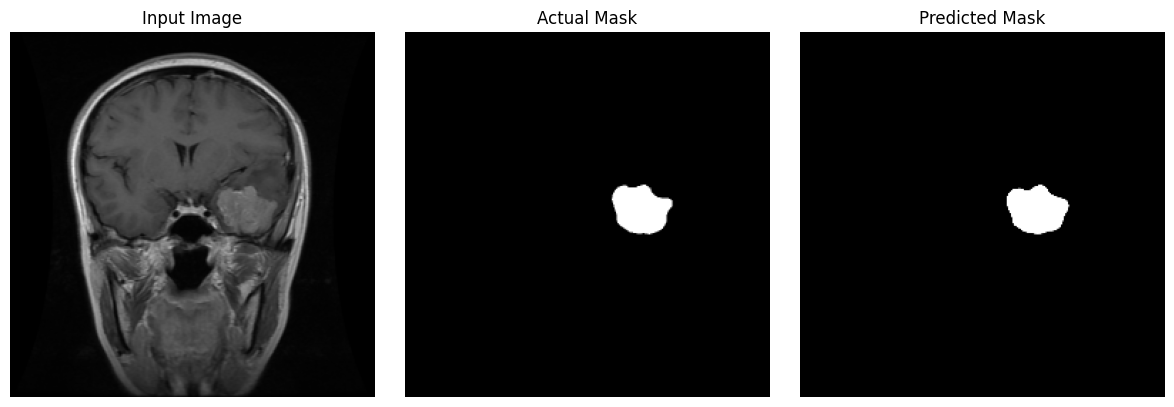

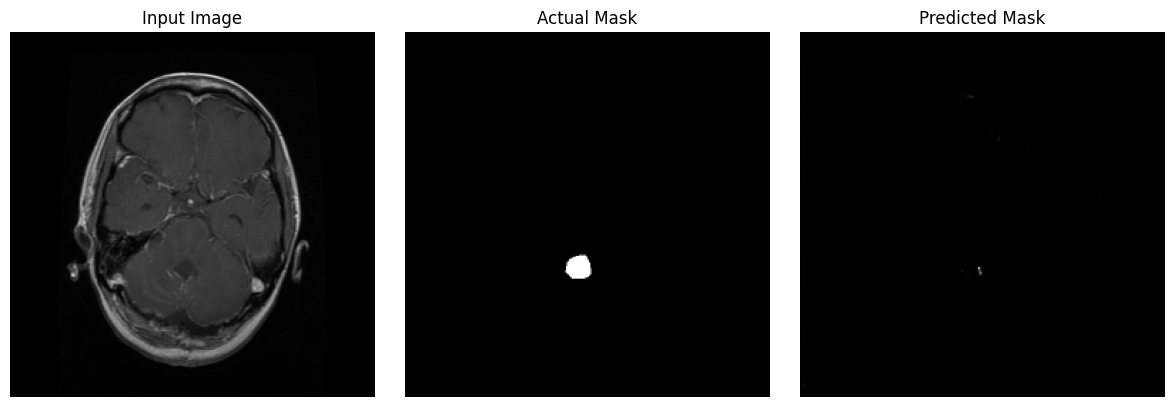

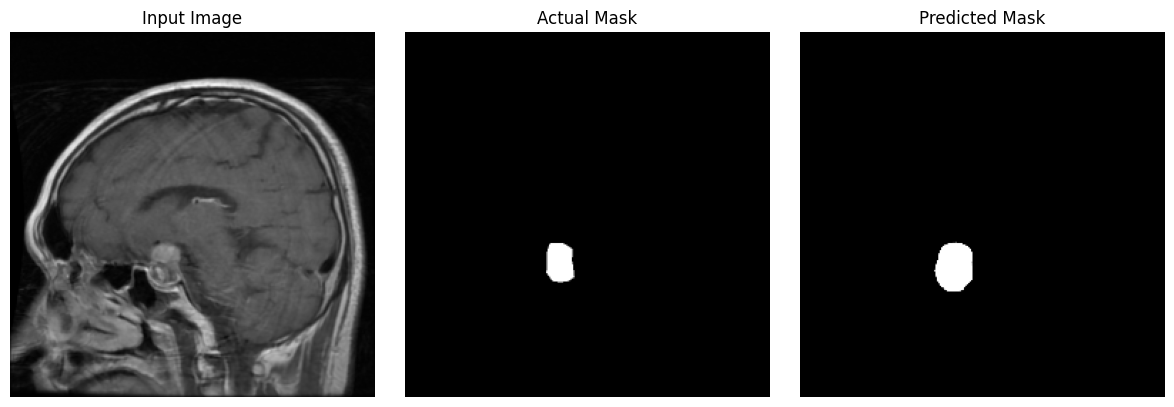

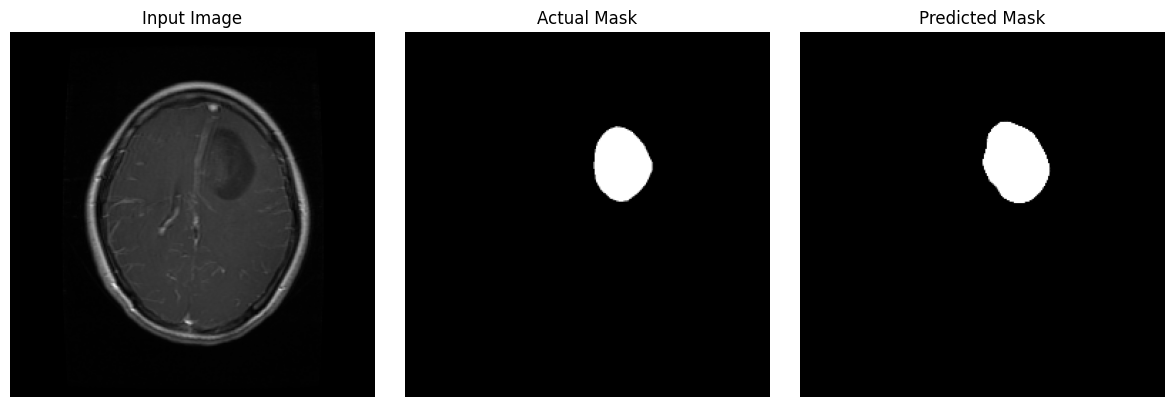

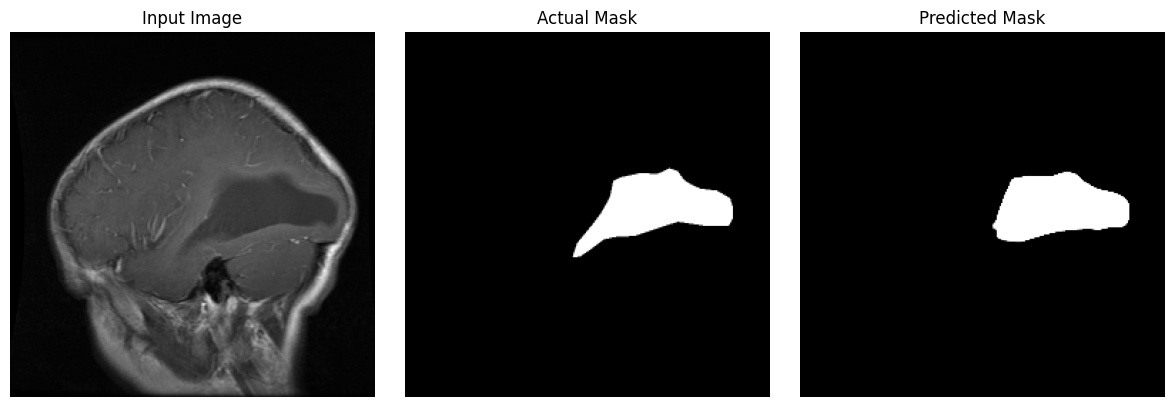

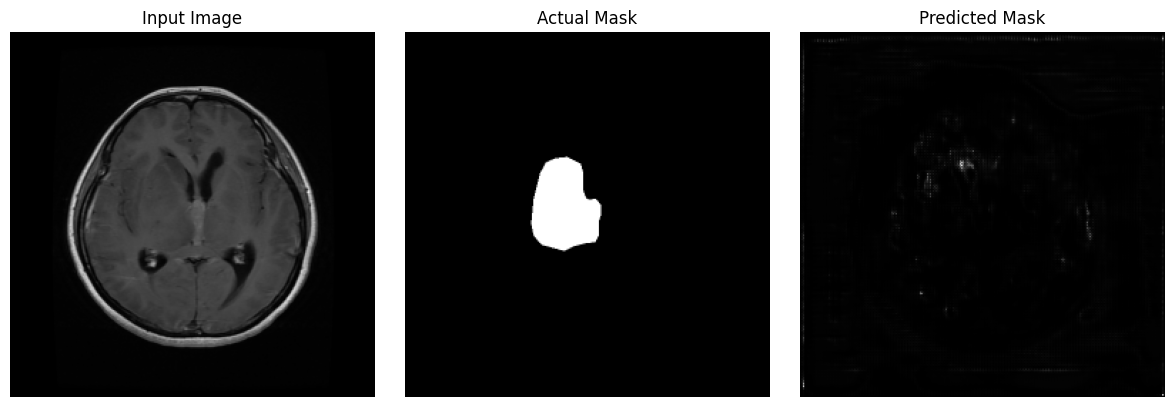

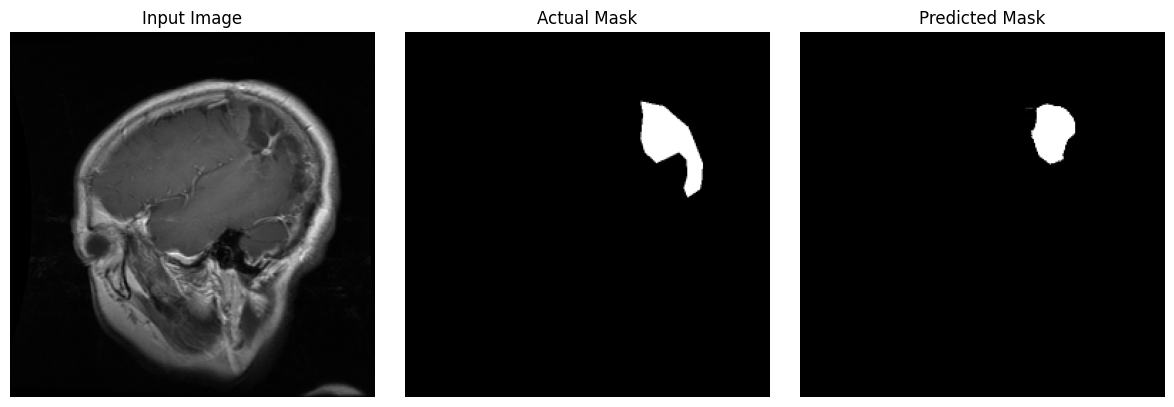

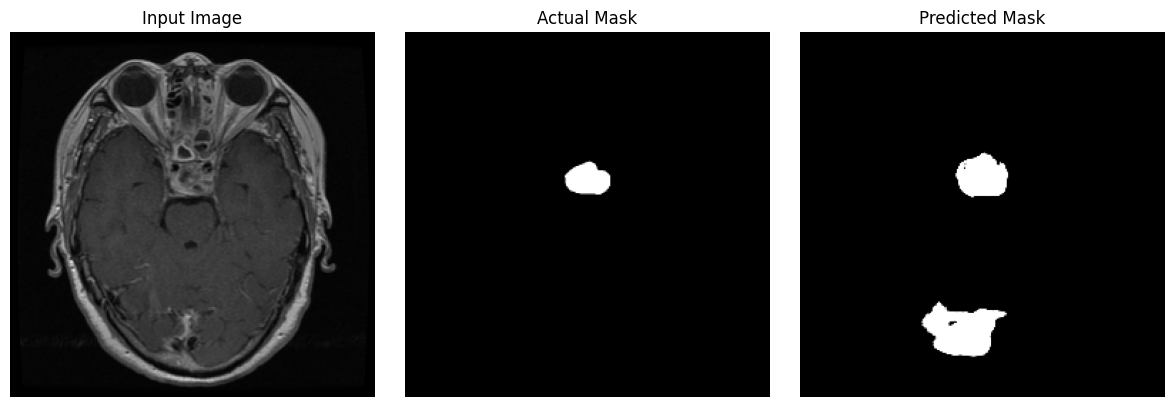

In [17]:
for i, (image, mask) in enumerate(test_dataset_brain.take(1)):
    predicted_mask = attention_unet.predict(image)

    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()